<a href="https://colab.research.google.com/github/bedoo96/-RAG-and-Hugging-Face/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# # # Installing libraries
# ! pip install --user transformers datasets torch faiss-cpu wget
# # ! pip install --user matplotlib scikit-learn
# # ! pip install wget

In [63]:
# ! pip install --user transformers datasets torch faiss-cpu

In [3]:
# ! pip uninstall wget
! pip install wget

In [4]:
import wget
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch

import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [5]:
# Define Helper functions

def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))

    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])

    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

In [6]:
# Download file

url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'
filename = 'compagnyPolicies.txt'

wget.download(url, out =filename)
print("file downloaded")

file downloaded


<h4>Reading and preprocessing data</h4>

In [7]:
def read_and_split_text(filename):
  try:
      with open(filename, 'r', encoding='utf-8') as file:
          text = file.read()
  except IOError as e:
    print(e)
  # Split the text into paragraphs (simple split by newline characters)
  paragraphs = text.split('\n')
      # Filter out any empty paragraphs or undesired entries
  paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
  return paragraphs



# Read the text file and split it into paragraphs
paragraphs = read_and_split_text('/content/compagnyPolicies.txt')
paragraphs[0:10]

['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

In [8]:
for i in range(4):
  print(f"sample : {i} paragraph : {paragraphs[i]} \n" )

sample : 0 paragraph : 1.	Code of Conduct 

sample : 1 paragraph : Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability. 

sample : 2 paragraph : Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest. 

sample : 3 paragraph : Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy. 



<h3>Building the retriever: Encoding and indexing</h3>

<p> In this case, we are going to use the Dense Passage Retriever(DPR) model, specifically the context encoder to convert the preprocessed text data into dense vector</p>

In [9]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [10]:
text = [('How are you?', 'I am fine'), ("What's up?","Not much")]
print(text)

[('How are you?', 'I am fine'), ("What's up?", 'Not much')]


In [11]:
# Tokens indexes
tokens_info = context_tokenizer(text, return_tensors='pt', padding=True, truncation= True, max_length= 256 )
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:
for s in tokens_info['input_ids']:
  print(context_tokenizer.convert_ids_to_tokens)

<bound method PreTrainedTokenizer.convert_ids_to_tokens of DPRContextEncoderTokenizer(name_or_path='facebook/dpr-ctx_encoder-single-nq-base', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)>
<bound 

In [13]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<p>The context_tokenizer and context_decoder work together to process data, transforming paragraphs into contextual embeddings suitable for further NLP tasks. Two concepts are important : </p>
<ol>
  <li><b>Padding : </b>To ensure uniformity, shorter text sequences are padded with zeros to reach the specified maximum length of 256 tokens.</li>
  <li><b>Truncation :</b> Longer texts are cut off at 256 tokens to maintain consistency across all inputs. </li>
</ol>

In [14]:
# shuffling samples so that are not oredered
random.shuffle(paragraphs)

In [15]:
tokens = context_tokenizer(paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens
outputs= context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.2705,  0.0480, -0.2070,  ..., -0.3734, -0.6568,  0.1409],
        [ 0.9413,  0.6287, -0.3240,  ..., -0.2420, -0.4934, -0.1796],
        [ 0.2240,  0.2006,  0.1992,  ...,  0.0155, -0.4007, -0.0060],
        ...,
        [ 0.5983,  0.3700,  0.6134,  ..., -0.2954, -0.4781,  0.3252],
        [ 0.6419,  0.7171,  0.1093,  ..., -0.4580, -0.8791, -0.1401],
        [ 0.8931,  0.5008, -0.1137,  ..., -0.5589,  0.1027, -0.0698]],
       grad_fn=<SliceBackward0>)

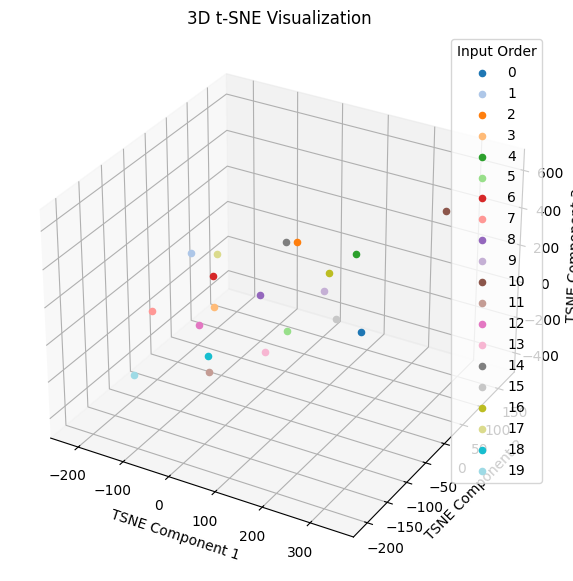

In [16]:
# apply t-SNE

tsne_plot(outputs.pooler_output.detach().numpy())

In [17]:
print("sample 16:", paragraphs[:16])

sample 16: ["Termination: In situations where an employee's performance or conduct issues persist, the organization may resort to termination. Termination may also occur for reasons such as redundancy, violation of policies, or restructuring.", 'Prohibited Substances: The use, possession, distribution, or sale of illegal drugs or unauthorized controlled substances is strictly prohibited on company premises or during work-related activities. This includes the misuse of prescription drugs.', 'Confidentiality: Reserve email for the transmission of confidential information, trade secrets, and sensitive customer data only when encryption is applied. Exercise discretion when discussing company matters on public forums or social media.', 'Designated Smoking Areas: Smoking is only permitted in designated smoking areas, as marked by appropriate signage. These areas have been chosen to minimize exposure to secondhand smoke and to maintain the overall cleanliness of the premises.', '2.\tRecruitme

In [18]:
embeddings =[]
for text in paragraphs[:5]:
  inputs = context_tokenizer(text, return_tensors ='pt', padding = True, truncation = True, max_length = 256 )
  outputs = context_encoder(**inputs)
  embeddings.append(outputs.pooler_output)
  print("number of samples")
  print(len(embeddings))
  print("samples shape")
  print(outputs.pooler_output.shape)

number of samples
1
samples shape
torch.Size([1, 768])
number of samples
2
samples shape
torch.Size([1, 768])
number of samples
3
samples shape
torch.Size([1, 768])
number of samples
4
samples shape
torch.Size([1, 768])
number of samples
5
samples shape
torch.Size([1, 768])


In [19]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

<h4>Let's consolidate all the steps into a function</h4>



In [20]:
def encode_context(text_list):
  # Encode a list of text into embeddings
  embeddings = []
  for text in text_list:
    inputs =  context_tokenizer(text, return_tensors ='pt', padding = True, truncation = True,  max_length = 256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
  return torch.cat(embeddings).detach().numpy()

In [21]:
# encode paragraph to create embeddings
context_embeddings = encode_context(paragraphs)

<h3>Creating and populating the FAISS index</h3>

In [22]:
! pip install faiss-cpu


In [23]:
!pip list | grep faiss


faiss-cpu                          1.10.0


In [24]:
import faiss
print(faiss.__version__)


1.10.0


In [25]:
import faiss

# convert list of numpy arrays into a single array
embedding_dim = 768
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np) # add the context embeddings to the index

<h3>DPR question encoder and tokenizer</h3>

In [26]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [27]:
# example question
question = "Drug and Alchool policy"
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embeddings = question_encoder(**question_inputs).pooler_output.detach().numpy()

# search index
D, I = index.search(question_embeddings, k =5)
print('D:', D)
print('I:', I)


D: [[85.50754  86.16458  90.148315 91.520775 93.22251 ]]
I: [[13 14 58 64 57]]


In [28]:
# Let'as print the top 5 relevant context
print(" Top 5 relevants context")
for i, idx in enumerate(I[0]):
  print(f"{i+1}: {paragraphs[idx]}")
  print(f"distance {D[0][i]}\n")

 Top 5 relevants context
1: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 85.50753784179688

2: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 86.16458129882812

3: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.1483154296875

4: 9.	Discipline and Termination Policy
distance 91.5207748413086

5: 6.	Drug and Alcohol Policy
distance 93.2225112915039



In [47]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

<h3>Enhancing response generation with LLMs Using GPT2 (Biderectional Auto-Regressive Tranformers)</h3>

In [30]:
tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')
model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2')
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [51]:
contexts =  "What is a large language model?"

In [52]:
# Tokenize the input text
inputs = tokenizer(contexts, return_tensors='pt', truncation = True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [53]:
# Use the LLM to generate the response
summary_ids = model.generate(inputs['input_ids'], max_length = 100, num_beams = 4, early_stopping = True, pad_token_id = tokenizer.eos_token_id )
summary_ids

tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257,
          1813,  4732,    13,   198,   198,    32,  1588,  3303,  2746,   318,
           257,   900,   286,  3173,   326,  6901,   703,   257,  3303,   815,
         17438,   287,   257,  1813,  4732,    13,   198,   198,    32,  1588,
          3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,   703,
           257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,   198]])

In [54]:
# Decode the generated token indexes back to text human readable
summary = tokenizer.decode(summary_ids[0], skip_special_tokens = True)
summary

'What is a large language model?\n\nA large language model is a set of rules that describe how a language should behave in a given context.\n\nA large language model is a set of rules that describe how a language should behave in a given context.\n\nA large language model is a set of rules that describe how a language should behave in a given context.\n\nA large language model is a set of rules that describe how a language should behave in a given context.\n'

<h3>Comparing answer generation: With and without DPR contexts</h3>

<h5>generating answers directly from questions</h5>

In [55]:
def generate_answer_without_context(question):
  #tokenize the input question
  inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation = True)
  # Generate output directly from the question qithout additional context
  summary_ids = model.generate(inputs['input_ids'], max_length = 150, min_length = 40, length_penalty = 2.0,
                               num_beams = 4, early_stopping = True, pad_token_id = tokenizer.eos_token_id)
  # Decode the generated token indexes back to text
  summary = tokenizer.decode(summary_ids[0], skip_special_tokens = True)
  return summary

In [56]:
# Example
question = " What is mobile Policy"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer:  What is mobile Policy?

Mobile Policy is the policy that governs the use of mobile devices in the United States. Mobile Policy is the policy that governs the use of mobile devices in the United States. Mobile Policy is the policy that governs the use of mobile devices in the United States. Mobile Policy is the policy that governs the use of mobile devices in the United States. Mobile Policy is the policy that governs the use of mobile devices in the United States. Mobile Policy is the policy that governs the use of mobile devices in the United States. Mobile Policy is the policy that governs the use of mobile devices in the United States. Mobile Policy is the policy that governs the use of mobile devices in the United States. Mobile Policy is the policy that governs


<h5>Generating answers with DPR contexts</h5>

In [57]:
def generate_answer(question, contexts):
    # Concatenate the retrieved contexts to form the input to GPT2
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [58]:
question = "what is mobile policy?"

_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

print(f"paragraphs indexs {I}")

paragraphs indexs [[56  8 58 51 17]]


In [59]:
# top paragraphes form query and contect retrieval
top_contexts = [paragraphs[idx] for idx in I[0]]
print(f"top_contexts {top_contexts}")

top_contexts ['4.\tMobile Phone Policy', 'The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance.', 'Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.']


In [60]:
# Assume I[0] contains indices of top contexts from the retrieval step
answer =  generate_answer (question, top_contexts)
print("Answer:", answer)

Answer: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets forth the standards and

<h4>Explore how adjusting generation parameters in GPT2 affects the quality</h4>

In [61]:
def generate_answer(contexts, max_len=50, min_len=40, length_penalty=2.0, num_beams=4):
    # Concatenate the retrieved contexts to form the input to BAR
    input_text = ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(
        inputs['input_ids'],
        max_new_tokens=max_len,
        min_length=min_len,
        length_penalty=length_penalty,
        num_beams=num_beams,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Define the question
question = "what is mobile policy?"

# Retrieve relevant contexts
_, I = search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)
top_contexts = [paragraphs[idx] for idx in I[0]]

# Test different generation settings
settings = [
    (50, 50, 1.0, 2),
    (120, 30, 2.0, 4),
    (100, 20, 2.5, 6)
]

# Generate and print answers for each setting
for setting in settings:
    answer = generate_answer(top_contexts, *setting)
    print(f"Settings: max_new_tokens={setting[0]}, min_length={setting[1]}, length_penalty={setting[2]}, num_beams={setting[3]}")
    print("Generated Answer:", answer)
    print("\n" + "="*80 + "\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=50, min_length=50, length_penalty=1.0, num_beams=2
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best p

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=120, min_length=30, length_penalty=2.0, num_beams=4
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best 